In [2]:
import shutil
from pathlib import Path

# === ベースディレクトリ ===
BASE_PATH = Path(r"C:\Users\sit\wavelet_CGAN\test2") 

# === データセット（data1, data2, data3 から選択）===
datasets = ["data1", "data2"]

# === 攻撃タイプ ===
attacks = ["FGSM", "CW"]

# === 作成するフォルダ一覧をまとめる ===
dirs = []

for ds in datasets:
    # 元画像フォルダ
    dirs.append(BASE_PATH / ds)

    for atk in attacks:
        atk_base = BASE_PATH / f"{ds}_{atk}"
        dirs.append(atk_base)                 # 例: data1_FGSM
        dirs.append(atk_base / "noise")       # ノイズ可視化
        dirs.append(atk_base / "tensor")      # 攻撃後 .pt

# === 共通フォルダ ===
common_dirs = [
    BASE_PATH / "wavelet_tensor",
    BASE_PATH / "pix2pix_restore_train_v2",
    BASE_PATH / "cgan_restore_failed",
    BASE_PATH / "results"
]

dirs.extend(common_dirs)

# === フォルダ作成 ===
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

# === 確認出力 ===
print("✅ 選択したデータセットに基づいてフォルダを作成しました:\n")
print("データセット:", datasets)
print("攻撃タイプ:", attacks)
print("\n作成フォルダ一覧:")
for d in dirs:
    print(" -", d)


✅ 選択したデータセットに基づいてフォルダを作成しました:

データセット: ['data1', 'data2']
攻撃タイプ: ['FGSM', 'CW']

作成フォルダ一覧:
 - C:\Users\sit\wavelet_CGAN\test2\data1
 - C:\Users\sit\wavelet_CGAN\test2\data1_FGSM
 - C:\Users\sit\wavelet_CGAN\test2\data1_FGSM\noise
 - C:\Users\sit\wavelet_CGAN\test2\data1_FGSM\tensor
 - C:\Users\sit\wavelet_CGAN\test2\data1_CW
 - C:\Users\sit\wavelet_CGAN\test2\data1_CW\noise
 - C:\Users\sit\wavelet_CGAN\test2\data1_CW\tensor
 - C:\Users\sit\wavelet_CGAN\test2\data2
 - C:\Users\sit\wavelet_CGAN\test2\data2_FGSM
 - C:\Users\sit\wavelet_CGAN\test2\data2_FGSM\noise
 - C:\Users\sit\wavelet_CGAN\test2\data2_FGSM\tensor
 - C:\Users\sit\wavelet_CGAN\test2\data2_CW
 - C:\Users\sit\wavelet_CGAN\test2\data2_CW\noise
 - C:\Users\sit\wavelet_CGAN\test2\data2_CW\tensor
 - C:\Users\sit\wavelet_CGAN\test2\wavelet_tensor
 - C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_train_v2
 - C:\Users\sit\wavelet_CGAN\test2\cgan_restore_failed
 - C:\Users\sit\wavelet_CGAN\test2\results


In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from pathlib import Path

# === ベースパス ===
BASE_PATH = Path(r"C:/Users/sit/wavelet_CGAN/test2")

# === 🔸 ここで処理したいデータセットを選択 ===
datasets = ["data1", "data2"]   # ← 必要に応じて ["data1"], ["data2","data3"] etc.

# === transform（AE生成前と整合） ===
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # [0,1]
])

for ds in datasets:
    input_dir = BASE_PATH / ds
    output_dir = BASE_PATH / f"{ds}_tensor"

    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n=== {ds} の Tensor 化を開始 ===")

    for fname in tqdm(sorted(os.listdir(input_dir))):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = input_dir / fname
        img = Image.open(img_path).convert("RGB")

        tensor = to_tensor(img).unsqueeze(0)  # [1,3,H,W]
        save_path = output_dir / (Path(fname).stem + ".pt")

        torch.save(tensor, save_path)

    print(f"✅ {ds} → Tensor 化完了: {output_dir}")

print("\n🎉 全データセットの Tensor 変換が完了しました！")



=== data1 の Tensor 化を開始 ===


100%|██████████| 1002/1002 [00:05<00:00, 182.36it/s]


✅ data1 → Tensor 化完了: C:\Users\sit\wavelet_CGAN\test2\data1_tensor

=== data2 の Tensor 化を開始 ===


100%|██████████| 1002/1002 [00:05<00:00, 178.53it/s]

✅ data2 → Tensor 化完了: C:\Users\sit\wavelet_CGAN\test2\data2_tensor

🎉 全データセットの Tensor 変換が完了しました！


In [ ]:
FGSM + CW Attack

In [5]:
# ==========================================================
# Attack Integrated Script (Multi Dataset + FGSM/CW + BOTH MODE)
#  - FGSM: 自前実装（Foolbox 不使用・top1 が変わる最小 ε を探索）
#  - CW  : これまで通り Foolbox L2CarliniWagnerAttack を使用
# ==========================================================

import os, re, torch, numpy as np, pandas as pd
import torchvision.transforms as T
from torchvision import models
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import foolbox as fb
import torch.nn as nn
from torch.nn import functional as F

# ==========================================================
# 0) 実行モード
# ==========================================================
run_mode = "both"     # ← "FGSM", "CW", "both"

# --- ★ データセット複数指定 ---
dataset_dirs = [
    r"C:\Users\sit\wavelet_CGAN\test2\data1",
    r"C:\Users\sit\wavelet_CGAN\test2\data2"
]

# ==========================================================
# 1) 共通設定
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_base = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
mobilenetv2 = models.mobilenet_v2(weights=weights).to(device).eval()

if "mean" in weights.meta and "std" in weights.meta:
    MEAN, STD = weights.meta["mean"], weights.meta["std"]
else:
    tinfo = weights.transforms()
    MEAN, STD = tinfo.mean, tinfo.std

imagenet_classes = weights.meta.get("categories", [f"class_{i}" for i in range(1000)])

# ----------------------------------------------------------
# Normalize
# ----------------------------------------------------------
class NormalizeModule(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor(std).view(1, 3, 1, 1))
    def forward(self, x):
        return (x - self.mean) / self.std

norm_layer = NormalizeModule(MEAN, STD)
model = nn.Sequential(norm_layer, mobilenetv2).to(device).eval()

# Foolbox（CW 用だけに使用）
fmodel = fb.PyTorchModel(model, bounds=(0, 1))

# ==========================================================
# Helper functions
# ==========================================================
def decode_img(path):
    img = Image.open(path).convert("RGB")
    return transform_base(img).unsqueeze(0)  # [1,3,224,224] in [0,1]

def to_torch_clipped(x):
    if isinstance(x, (tuple, list)):
        x = x[0]
    if isinstance(x, np.ndarray):
        t = torch.from_numpy(x)
    else:
        t = x.clone().detach()
    if t.dim() == 3:
        t = t.unsqueeze(0)
    return t.float().cpu().clamp(0, 1)

def save_tensor_image(t, path):
    t = t.detach().cpu()
    arr = (t.squeeze(0).numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    Image.fromarray(arr).save(path)

def save_noise_vis(orig, adv, path):
    o = orig.squeeze(0).detach().cpu().numpy()
    a = adv.squeeze(0).detach().cpu().numpy()
    diff = o - a
    mag = np.max(np.abs(diff)) + 1e-8
    vis = diff / (2 * mag) + 0.5
    arr = (vis.transpose(1, 2, 0) * 255).astype(np.uint8)
    Image.fromarray(arr).save(path)

def extract_number(p: Path):
    m = re.search(r'\d+', p.stem)
    return int(m.group()) if m else float('inf')

def pred(x):
    """
    x: [1,3,224,224] in [0,1] (CPU/GPU どちらでも可)
    """
    with torch.no_grad():
        out = model(x.to(device))
        prob = F.softmax(out, 1)
        conf, idx = torch.max(prob, 1)
        idx = idx.item()
        return idx, imagenet_classes[idx], float(conf.item())

# ==========================================================
# FGSM（自前実装・gradient 1回で eps をスイープ）
# ==========================================================
def perform_fgsm(images, labels, max_eps=1.0, steps=1000):
    """
    images : [1,3,224,224] in [0,1] (device 上)
    labels : tensor([orig_idx]) on device
    max_eps: 最大 ε
    steps  : ε を何分割するか
    戻り値 : (adv_cpu_tensor, used_eps, adv_idx) or (None, max_eps, orig_idx)
    """

    # 1) 元画像でのラベル確認
    orig_idx, _, _ = pred(images)

    # 2) 勾配計算（1回だけ）
    x = images.detach().clone().to(device)
    x.requires_grad_(True)

    logits = model(x)
    loss = F.cross_entropy(logits, labels)
    model.zero_grad()
    loss.backward()

    grad_sign = x.grad.detach().sign()  # FGSM の方向

    # 3) ε を 0→max_eps まで少しずつ増やしながら top-1 をチェック
    eps_step = max_eps / steps
    eps = 0.001

    for _ in range(steps):
        eps += eps_step
        adv = x + eps * grad_sign
        adv = torch.clamp(adv, 0.0, 1.0)

        adv_idx, _, _ = pred(adv)

        if adv_idx != orig_idx:
            # CPU tensor で返す（保存用）
            return adv.detach().cpu(), eps, adv_idx

    # ここまで来たら攻撃失敗（max_eps まで変わらず）
    return None, max_eps, orig_idx

# ==========================================================
# CW（従来通り Foolbox）
# ==========================================================
def perform_cw(fmodel_local, images, labels, steps=100, binary=10, confidence=0.0):
    attack = fb.attacks.L2CarliniWagnerAttack(
        steps=steps,
        binary_search_steps=binary,
        confidence=confidence
    )
    raw, clipped, is_adv = attack(fmodel_local, images, labels, epsilons=None)

    if clipped is None:
        return None, None, None

    clipped_t = to_torch_clipped(clipped)   # CPU
    clipped_gpu = clipped_t.to(device)      # 分類用

    l2 = torch.norm((images - clipped_gpu).reshape(1, -1), p=2).item()

    adv_idx, _, _ = pred(clipped_gpu)
    orig_idx, _, _ = pred(images)

    if adv_idx != orig_idx:
        return clipped_t, l2, adv_idx
    else:
        return None, l2, orig_idx

# ==========================================================
# ★ データセットごとに攻撃
# ==========================================================
def run_attack(dataset_path, attack_type):

    dataset_path = Path(dataset_path)

    print(f"\n==============================")
    print(f"▶ {dataset_path.name} → {attack_type} Attack Start")
    print(f"==============================")

    output_dir = Path(str(dataset_path) + f"_{attack_type}")
    noise_dir = output_dir / "noise"
    tensor_dir = output_dir / "tensor"

    for d in [output_dir, noise_dir, tensor_dir]:
        d.mkdir(parents=True, exist_ok=True)

    AE_results = []

    image_files = sorted(
        [f for f in dataset_path.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png"]],
        key=extract_number
    )

    for i, img_path in enumerate(tqdm(image_files)):
        images = decode_img(img_path).to(device)     # [1,3,224,224] in [0,1]
        orig_idx, orig_name, orig_conf = pred(images)
        labels = torch.tensor([orig_idx], dtype=torch.long, device=device)

        if attack_type == "FGSM":
            clipped, val, adv_lb = perform_fgsm(images, labels, max_eps=1.0, steps=1000)
        else:
            clipped, val, adv_lb = perform_cw(fmodel, images, labels)

        if clipped is not None:
            # clipped: CPU tensor [1,3,224,224] in [0,1]
            adv_idx, adv_name, adv_conf = pred(clipped.to(device))

            tensor_path = tensor_dir / f"{img_path.stem}.pt"
            torch.save(clipped.cpu(), tensor_path)

            save_tensor_image(clipped, output_dir / f"{img_path.stem}.jpg")
            save_noise_vis(images, clipped.to(device), noise_dir / f"noise_{i}.jpg")

            row = {
                "image": img_path.name,
                "Original_label": orig_idx,
                "Original_label_name": orig_name,
                "Original_confidence": orig_conf,
                "Advs_label": adv_idx,
                "Advs_label_name": adv_name,
                "Advs_confidence": adv_conf,
                "Tensor_path": str(tensor_path)
            }

            if attack_type == "FGSM":
                row["Advs_eps"] = float(val)
            else:
                row["L2_Distance"] = float(val)

            AE_results.append(row)

    df = pd.DataFrame(AE_results)
    df.to_csv(output_dir / f"{attack_type}_Results.csv", index=False, encoding="utf-8-sig")

    print(f"▶ 完了: {attack_type} → {output_dir}")

# ==========================================================
# ★ 実行（すべてのデータセットに対して）
# ==========================================================
for dataset in dataset_dirs:
    if run_mode.lower() == "both":
        run_attack(dataset, "FGSM")
        run_attack(dataset, "CW")
    else:
        run_attack(dataset, run_mode)



▶ data1 → FGSM Attack Start


100%|██████████| 1000/1000 [01:11<00:00, 14.03it/s]


▶ 完了: FGSM → C:\Users\sit\wavelet_CGAN\test2\data1_FGSM

▶ data1 → CW Attack Start


100%|██████████| 1000/1000 [40:39<00:00,  2.44s/it]


▶ 完了: CW → C:\Users\sit\wavelet_CGAN\test2\data1_CW

▶ data2 → FGSM Attack Start


100%|██████████| 1000/1000 [01:14<00:00, 13.51it/s]


▶ 完了: FGSM → C:\Users\sit\wavelet_CGAN\test2\data2_FGSM

▶ data2 → CW Attack Start


100%|██████████| 1000/1000 [41:24<00:00,  2.48s/it] 

▶ 完了: CW → C:\Users\sit\wavelet_CGAN\test2\data2_CW


In [6]:
# ==========================================================
# Wavelet分類回復（datasets × attacks 自動処理）
# data1_FGSM, data1_CW, data2_FGSM などを自動探索
# ==========================================================

import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import pywt
from pathlib import Path
from tqdm import tqdm


# ==========================================================
# === Waveletノイズ除去 ===
# ==========================================================
def wavelet_denoise(img_tensor, wavelet='haar', level=1, threshold=0.07):
    img_tensor = img_tensor.detach().cpu()
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)

    img_np = img_tensor.numpy()
    denoised = []

    for b in range(img_np.shape[0]):
        out_c = []
        for c in range(img_np[b].shape[0]):
            coeffs = pywt.wavedec2(img_np[b, c], wavelet, level=level)
            cA, cD = coeffs[0], coeffs[1:]
            cD_new = []
            for (cH, cV, cD_) in cD:
                cH = pywt.threshold(cH, threshold*np.max(np.abs(cH)))
                cV = pywt.threshold(cV, threshold*np.max(np.abs(cV)))
                cD_ = pywt.threshold(cD_, threshold*np.max(np.abs(cD_)))
                cD_new.append((cH, cV, cD_))
            coeffs_new = [cA] + cD_new
            rec = pywt.waverec2(coeffs_new, wavelet)
            rec = rec[:img_np.shape[2], :img_np.shape[3]]
            out_c.append(rec)
        denoised.append(np.stack(out_c))

    return torch.tensor(np.stack(denoised)).float().clamp(0,1)


# ==========================================================
# === MobileNetV2 ロード ===
# ==========================================================
def load_model(device):
    model = models.mobilenet_v2(
        weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
    ).to(device).eval()

    normalize = T.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
    return model, normalize


def predict(model, img_tensor, normalize):
    with torch.no_grad():
        preds = F.softmax(model(normalize(img_tensor)), dim=1)
        conf, idx = preds.max(1)
        return int(idx.item()), float(conf.item())


# ==========================================================
# === Wavelet処理メイン ===
# ==========================================================
def process_wavelet_folder(folder):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder = Path(folder)

    tensor_dir = folder / "tensor"
    if not tensor_dir.exists():
        print(f"[SKIP] tensor が無いのでスキップ → {folder}")
        return

    print(f"\n=============================================")
    print(f"▶ Wavelet処理開始: {folder.name}")
    print("=============================================")

    # 出力フォルダ
    output_root = folder / "wavelet_eval"
    out_tensor_dir = output_root / "wavelet_tensor"
    out_image_dir = output_root / "wavelet_images"
    out_tensor_dir.mkdir(parents=True, exist_ok=True)
    out_image_dir.mkdir(parents=True, exist_ok=True)

    model, normalize = load_model(device)
    results = []

    for fname in tqdm(sorted(os.listdir(tensor_dir))):
        if not fname.endswith(".pt"):
            continue

        name = fname.replace(".pt", "")
        t = torch.load(tensor_dir / fname)

        if t.ndim == 3:
            t = t.unsqueeze(0)

        # Wavelet
        w = wavelet_denoise(t)

        # GPUへ
        w_gpu = w.to(device)

        # 分類
        label_id, conf = predict(model, w_gpu, normalize)
        label_name = models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"][label_id]

        # 保存
        torch.save(w.cpu(), out_tensor_dir / f"{name}_wavelet.pt")
        save_image(w.cpu(), out_image_dir / f"{name}_wavelet.png")

        results.append({
            "ImageId": name,
            "Wavelet_Label": label_name,
            "Wavelet_Confidence": round(conf, 6),
        })

    out_csv = output_root / f"{folder.name}_Wavelet_class_results.csv"
    pd.DataFrame(results).to_csv(out_csv, index=False, encoding="utf-8-sig")

    print(f"➡ 完了: {out_csv}")


# ==========================================================
# ★ datasets × attacks を自動ループで処理 ★
# ==========================================================

# --- データセット（必要に応じて追加） ---
datasets = ["data1", "data2"]   # ← ここを自由に設定

# --- 攻撃タイプ ---
attacks = ["FGSM", "CW"]

base_root = r"C:\Users\sit\wavelet_CGAN\test2"

# --- 自動実行 ---
for ds in datasets:
    for atk in attacks:
        folder = Path(base_root) / f"{ds}_{atk}"
        process_wavelet_folder(folder)



▶ Wavelet処理開始: data1_FGSM


100%|██████████| 1000/1000 [00:30<00:00, 33.10it/s]


➡ 完了: C:\Users\sit\wavelet_CGAN\test2\data1_FGSM\wavelet_eval\data1_FGSM_Wavelet_class_results.csv

▶ Wavelet処理開始: data1_CW


100%|██████████| 1000/1000 [00:29<00:00, 33.68it/s]


➡ 完了: C:\Users\sit\wavelet_CGAN\test2\data1_CW\wavelet_eval\data1_CW_Wavelet_class_results.csv

▶ Wavelet処理開始: data2_FGSM


100%|██████████| 1000/1000 [00:29<00:00, 33.63it/s]


➡ 完了: C:\Users\sit\wavelet_CGAN\test2\data2_FGSM\wavelet_eval\data2_FGSM_Wavelet_class_results.csv

▶ Wavelet処理開始: data2_CW


100%|██████████| 1000/1000 [00:29<00:00, 33.34it/s]

➡ 完了: C:\Users\sit\wavelet_CGAN\test2\data2_CW\wavelet_eval\data2_CW_Wavelet_class_results.csv


In [1]:
### -*- coding: utf-8 -*-
# ==========================================================
# Wavelet＋CGAN復元＋4段階比較＆成功率判定
# （旧仕様：tensor_out 保存版）
# ==========================================================

import os
import sys
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from torchvision import models
from torchvision.utils import save_image
from torch import nn
from tqdm import tqdm
from shutil import copy2

# ========= 0) 再現性（任意） =========
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ========= 1) 共通設定 =========
BASE = Path(r"C:\Users\sit\wavelet_CGAN\test2")

DATASETS = ["data1", "data2"]
ATTACKS  = ["FGSM"]      # ["FGSM", "CW"] にしてもOK
LEGACY_PREPROCESS = True

WEIGHT_PATH = BASE / "GAN_train" /"pix2pix_train" / "weights" / "gen_weights_epoch700.pth"

# ========= 2) 存在チェック =========
def _must_exist(p: Path, hint: str = ""):
    if not p.exists():
        print(f"\n[ERROR] Not found: {p}")
        if hint:
            print("Hint:", hint)
        sys.exit(1)

# ========= 3) MobileNetV2 =========
def load_classifier(device):
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
    model = models.mobilenet_v2(weights=weights).to(device).eval()
    categories = weights.meta["categories"]

    if LEGACY_PREPROCESS:
        preprocess = weights.transforms()   # Resize/Crop 含む
    else:
        from torchvision import transforms as T
        preprocess = T.Normalize(mean=weights.meta["mean"], std=weights.meta["std"])

    return model, preprocess, categories

# ========= 4) CGAN Generator（旧仕様）=========
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        self.encoder = nn.Sequential(
            self.block(in_channels, features, normalize=False),
            self.block(features, features * 2),
            self.block(features * 2, features * 4),
            self.block(features * 4, features * 8),
            self.block(features * 8, features * 8),
        )

        self.decoder = nn.ModuleList([
            self.upblock(features * 8,     features * 8),
            self.upblock(features * 8 * 2, features * 4),
            self.upblock(features * 4 * 2, features * 2),
            self.upblock(features * 2 * 2, features),
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh(),
        ])

    def block(self, in_c, out_c, normalize=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def upblock(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        skips = []

        # Encoder
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)

        x = skips[-1]
        skips = skips[:-1][::-1]

        # Decoder with skip connections
        for i in range(4):
            x = self.decoder[i](x)
            x = torch.cat([x, skips[i]], dim=1)

        # Final conv
        x = self.decoder[4](x)

        # Tanh
        return self.decoder[5](x)


# ========= 5) データセット×攻撃ごとに処理 =========
def process_dataset_attack(dataset: str, attack_type: str):

    print("\n" + "=" * 60)
    print(f"▶ 開始: {dataset} / {attack_type}")
    print("=" * 60 + "\n")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- パス -----
    clean_dir = BASE / dataset
    adv_dir   = BASE / f"{dataset}_{attack_type}"
    wavelet_dir = adv_dir / "wavelet_eval"
    tensor_dir  = wavelet_dir / "wavelet_tensor"
    wavelet_png_dir = wavelet_dir / "wavelet_images"

    cgan_out_dir = BASE / "pix2pix_restore_train_v2" / f"{dataset}_{attack_type}"
    cgan_out_dir.mkdir(parents=True, exist_ok=True)

    # ★ CGAN Tensor 保存フォルダ
    tensor_out_dir = cgan_out_dir / "tensor_out"
    tensor_out_dir.mkdir(parents=True, exist_ok=True)

    cgan_csv   = cgan_out_dir / f"pix2pix_class_results_{dataset}_{attack_type}.csv"
    merged_csv = cgan_out_dir / f"compare_{dataset}_{attack_type}_Wavelet_CGAN.csv"

    before_csv  = clean_dir / "clean_dataset_labels.csv"
    after_csv   = adv_dir / f"{attack_type}_Results.csv"
    wavelet_csv = wavelet_dir / f"{dataset}_{attack_type}_Wavelet_class_results.csv"

    wavelet_failed_dir = BASE / "wavelet_restore_failed" / f"{dataset}_{attack_type}"
    cgan_failed_dir    = BASE / "cgan_restore_failed"    / f"{dataset}_{attack_type}"
    wavelet_failed_dir.mkdir(parents=True, exist_ok=True)
    cgan_failed_dir.mkdir(parents=True, exist_ok=True)

    failed_list_csv = cgan_out_dir / f"failed_lists_{dataset}_{attack_type}.csv"

    # チェック
    _must_exist(before_csv)
    _must_exist(after_csv)
    _must_exist(wavelet_csv)
    _must_exist(tensor_dir)
    _must_exist(WEIGHT_PATH)

    # ========= 5-1) CGAN復元＋分類 =========
    def restore_and_classify():

        gen = UNetGenerator().to(device)
        gen.load_state_dict(torch.load(WEIGHT_PATH, map_location=device))
        gen.eval()

        clf, preprocess, categories = load_classifier(device)
        results = []

        print(f"\n=== CGAN推論＋分類 ({dataset}/{attack_type}) ===\n")

        with torch.no_grad():
            for fname in tqdm(sorted(os.listdir(tensor_dir))):
                if not fname.endswith(".pt"):
                    continue

                t = torch.load(tensor_dir / fname, map_location=device)
                if t.ndim == 3:
                    t = t.unsqueeze(0)

                # 正規化
                if t.min() >= 0 and t.max() <= 1:
                    t_in = (t - 0.5) / 0.5
                else:
                    t_in = t

                restored = gen(t_in.to(device))
                restored_01 = (restored * 0.5 + 0.5).clamp(0, 1)

                base = Path(fname).stem.replace("_wavelet", "")

                # ★ CGAN 出力 Tensor 保存（重要！）
                torch.save(restored.cpu(), tensor_out_dir / f"{base}.pt")

                # PNG 保存
                out_png = cgan_out_dir / f"{base}_{attack_type}_restored.png"
                save_image(restored_01.cpu(), out_png)

                # 分類
                x = restored_01.squeeze(0).cpu()
                x = preprocess(x).unsqueeze(0).to(device)
                preds = F.softmax(clf(x), dim=1)

                conf, idx = preds.max(1)
                label = categories[int(idx)]

                results.append({
                    "ImageId": base,
                    "CGAN_Label": label,
                    "CGAN_Confidence": float(conf),
                })

        pd.DataFrame(results).to_csv(cgan_csv, index=False, encoding="utf-8-sig")
        print(f"✔ CGAN分類結果CSV: {cgan_csv}")
        print(f"✔ Tensor保存先: {tensor_out_dir}")

    # ========= 5-2) 4段階CSV統合 =========
    def merge_and_evaluate():

        print(f"\n=== 4段階CSV統合 ({dataset}/{attack_type}) ===\n")

        df_b = pd.read_csv(before_csv)
        df_a = pd.read_csv(after_csv)
        df_w = pd.read_csv(wavelet_csv)
        df_g = pd.read_csv(cgan_csv)

        df_b["ImageId"] = df_b["image"].apply(lambda x: Path(str(x)).stem)
        df_a["ImageId"] = df_a["image"].apply(lambda x: Path(str(x)).stem)
        df_g["ImageId"] = df_g["ImageId"].astype(str)

        df_b = df_b.rename(columns={"label_name":"label_name_before",
                                    "confidence":"confidence_before"})
        df_a = df_a.rename(columns={"Advs_label_name":"label_name_after",
                                    "Advs_confidence":"confidence_after"})

        df = (df_b.merge(df_a, on="ImageId", how="inner")
                 .merge(df_w, on="ImageId", how="left")
                 .merge(df_g, on="ImageId", how="left"))

        df["AttackSuccess"] = df["label_name_before"] != df["label_name_after"]
        df["RecoverySuccess_Wavelet"] = df["label_name_before"] == df["Wavelet_Label"]
        df["RecoverySuccess_CGAN"]    = df["label_name_before"] == df["CGAN_Label"]

        df.to_csv(merged_csv, index=False, encoding="utf-8-sig")
        print(f"✔ 統合CSV: {merged_csv}")

        # 成功率
        total = len(df)
        atk = int(df["AttackSuccess"].sum())
        w_ok = int(df["RecoverySuccess_Wavelet"].sum())
        g_ok = int(df["RecoverySuccess_CGAN"].sum())
        pct = lambda n: (n/total*100.0) if total else 0.0

        print("\n=== 統計 ===")
        print(f"総数: {total}")
        print(f"攻撃成功数: {atk}/{total} ({pct(atk):.2f}%)")
        print(f"Wavelet矯正成功数: {w_ok}/{total} ({pct(w_ok):.2f}%)")
        print(f"CGAN矯正成功数: {g_ok}/{total} ({pct(g_ok):.2f}%)")

        # ---- 失敗画像保存 ----
        wavelet_failed = df[df["RecoverySuccess_Wavelet"] == False]
        for _, row in wavelet_failed.iterrows():
            img_id = row["ImageId"]
            src = wavelet_png_dir / f"{img_id}_wavelet.png"
            if src.exists():
                copy2(src, wavelet_failed_dir / src.name)

        cgan_failed = df[df["RecoverySuccess_CGAN"] == False]
        for _, row in cgan_failed.iterrows():
            img_id = row["ImageId"]
            src = cgan_out_dir / f"{img_id}_{attack_type}_restored.png"
            if src.exists():
                copy2(src, cgan_failed_dir / src.name)

        failed_concat = pd.concat(
            [wavelet_failed.assign(FailStage="Wavelet"),
             cgan_failed.assign(FailStage="CGAN")],
            ignore_index=True
        )

        if len(failed_concat) > 0:
            failed_concat.to_csv(failed_list_csv, index=False, encoding="utf-8-sig")
            print(f"📝 失敗一覧CSV: {failed_list_csv}")

    # ===== 実行 =====
    restore_and_classify()
    merge_and_evaluate()


# ========= 6) 一括実行 =========
if __name__ == "__main__":

    _must_exist(WEIGHT_PATH)

    for ds in DATASETS:
        for atk in ATTACKS:
            process_dataset_attack(ds, atk)

    print("\n=== Wavelet＋CGAN 全処理完了 ===\n")



▶ 開始: data1 / FGSM


=== CGAN推論＋分類 (data1/FGSM) ===



  9%|▊         | 86/1000 [00:04<00:48, 18.70it/s]


KeyboardInterrupt: 

In [ ]:
評価・考察

✅ 日本語フォント設定を 'MS Gothic' にしました。

--- グラフ描画開始: FGSM攻撃におけるEpsilon値分布 ---


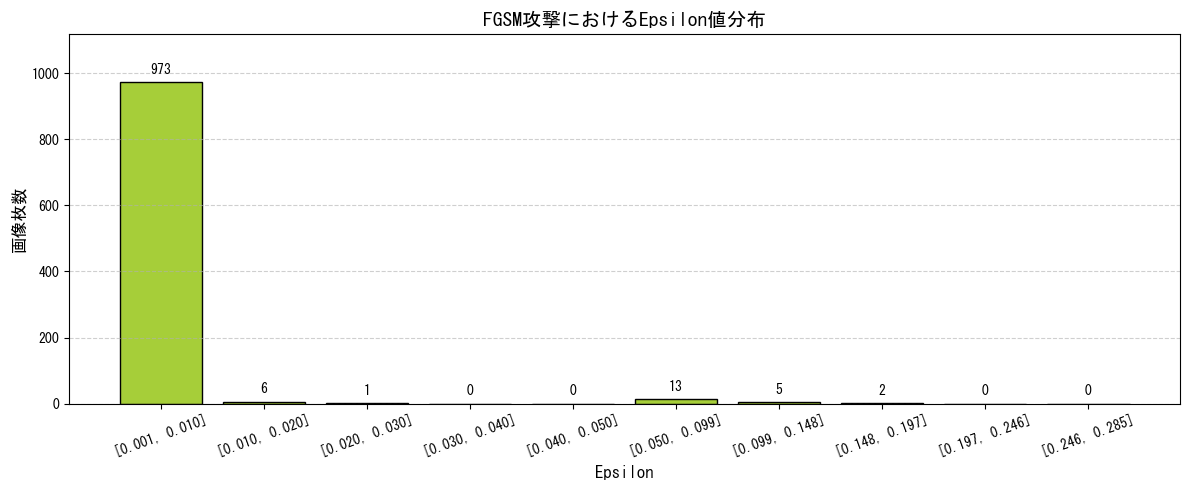


--- グラフ描画開始: CW攻撃におけるL2距離分布 ---


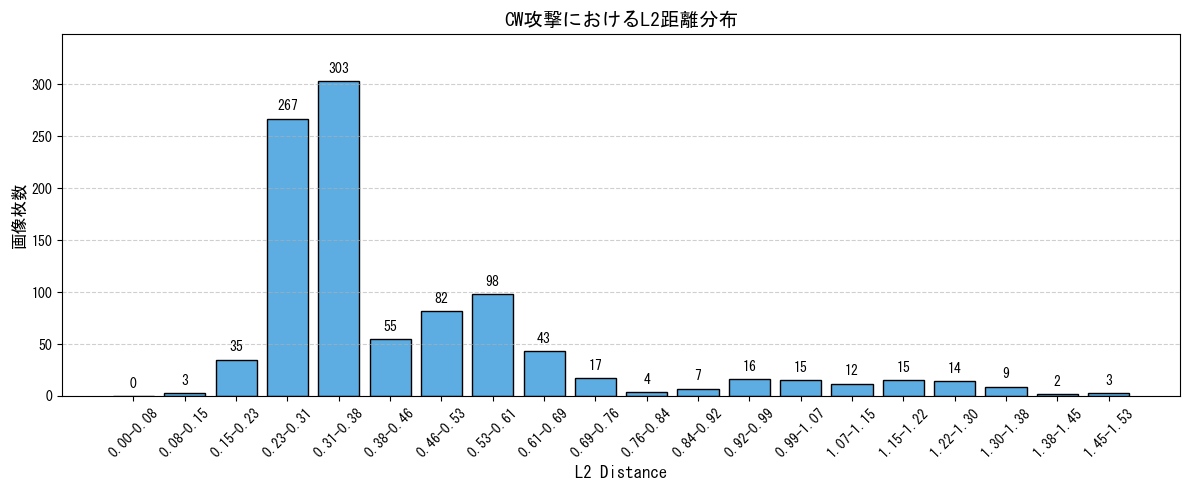


=== 全てのグラフ描画が完了しました。 ===


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pathlib import Path

# ==========================================================
# 🌟 設定箇所 🌟
# ==========================================================

# ベースディレクトリ
BASE_DIR = Path(r"C:\Users\sit\wavelet_CGAN")

# 処理したい攻撃設定のリスト
ATTACK_CONFIGS = [
    {
        "data_folder": "test2",        # 'test2' フォルダを基準
        "dataset_name": "data2",       
        "attack_type": "FGSM",         
        "column_name": "Advs_eps",
        "title": "FGSM攻撃におけるEpsilon値分布",
        "xlabel": "Epsilon",
        # ★修正ポイント: 画像の階級に合わせてビンを調整（0.010, 0.020, ... を区切りに設定）
        "bins": [0.001, 0.010, 0.020, 0.030, 0.040, 0.050, 0.099, 0.148, 0.197, 0.246, 0.285],
        "color": "#A6CE39",
        "rotation": 20
    },
    {
        "data_folder": "test2",
        "dataset_name": "data2",       
        "attack_type": "CW",           
        "column_name": "L2_Distance",
        "title": "CW攻撃におけるL2距離分布",
        "xlabel": "L2 Distance",
        "bins": 20,                    # ビン数 (自動計算)
        "color": "#5DADE2",
        "rotation": 45
    },
    # ★追加したい攻撃設定があれば、ここに辞書形式で追記してください★
]

# ==========================================================
# 共通処理とユーティリティ
# ==========================================================

# 日本語フォント設定（Windows用）を共通化
try:
    mpl.rcParams['font.family'] = 'MS Gothic'
    print("✅ 日本語フォント設定を 'MS Gothic' にしました。")
except Exception:
    print("⚠️ 警告: MS Gothicフォントが見つからないか、設定に失敗しました。")

def get_csv_path(config):
    """設定に基づいてCSVの完全なパスを構築します。"""
    # BASE_DIR / data_folder / dataset_name_attack_type / attack_type_Results.csv
    folder = Path(config["data_folder"]) / f'{config["dataset_name"]}_{config["attack_type"]}'
    filename = f'{config["attack_type"]}_Results.csv'
    return BASE_DIR / folder / filename

def plot_distribution(csv_path, column_name, title, xlabel, bins_or_num, color, rotation=20):
    """
    指定されたCSVファイルからデータを読み込み、ヒストグラムとして描画します。
    """
    print(f"\n--- グラフ描画開始: {title} ---")
    
    if not Path(csv_path).exists():
        print(f"❌ エラー: CSVファイルが見つかりません: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    
    if column_name not in df.columns:
        print(f"❌ エラー: 列 '{column_name}' がCSVファイルに見つかりません。")
        return

    values = df[column_name].values
    if values.size == 0:
         print(f"⚠️ 警告: データが空のため、グラフを描画できません。")
         return

    # ビンの計算
    if isinstance(bins_or_num, list):
        bins = bins_or_num
        counts, bin_edges = np.histogram(values, bins=bins)
        # 階級ラベルの生成 (FGSM画像に合わせて小数点以下3桁)
        bin_labels = [f"[{bins[i]:.3f}, {bins[i+1]:.3f}]" for i in range(len(bins)-1)]
    else:
        bins_num = bins_or_num
        bins = np.linspace(0, values.max(), bins_num + 1)
        counts, bin_edges = np.histogram(values, bins=bins)
        # 階級ラベルの生成 (CWに合わせて小数点以下2桁)
        bin_labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]


    # === グラフ描画 ===
    plt.figure(figsize=(12, 5))
    x_positions = np.arange(len(counts))
    
    plt.bar(x_positions, counts, width=0.8, color=color, edgecolor="black")

    # === 棒グラフの上に値を表示 ===
    max_count = max(counts)
    for i, count in enumerate(counts):
        plt.text(x_positions[i], count + (max_count * 0.02), str(count), 
                 ha="center", va="bottom", fontsize=10)

    # === 描画設定 ===
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("画像枚数", fontsize=12)
    plt.xticks(x_positions, bin_labels, rotation=rotation)
    
    plt.ylim(0, max_count * 1.15)
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ==========================================================
# 実行本体
# ==========================================================
if __name__ == "__main__":
    
    for config in ATTACK_CONFIGS:
        csv_path = get_csv_path(config)
        
        # グラフ描画を実行
        plot_distribution(
            csv_path=csv_path, 
            column_name=config["column_name"], 
            title=config["title"], 
            xlabel=config["xlabel"], 
            bins_or_num=config["bins"], 
            color=config["color"],
            rotation=config["rotation"]
        )

    print("\n=== 全てのグラフ描画が完了しました。 ===")

✅ フォント設定: Meiryo を使用します。


C:\Users\sit\AppData\Local\Temp\ipykernel_10572\1676188370.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wavelet_rates = df.groupby("wavelet_bin")["RecoverySuccess_Wavelet"].mean().values * 100
C:\Users\sit\AppData\Local\Temp\ipykernel_10572\1676188370.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cgan_rates    = df.groupby("cgan_bin")   ["RecoverySuccess_CGAN"].mean().values * 100


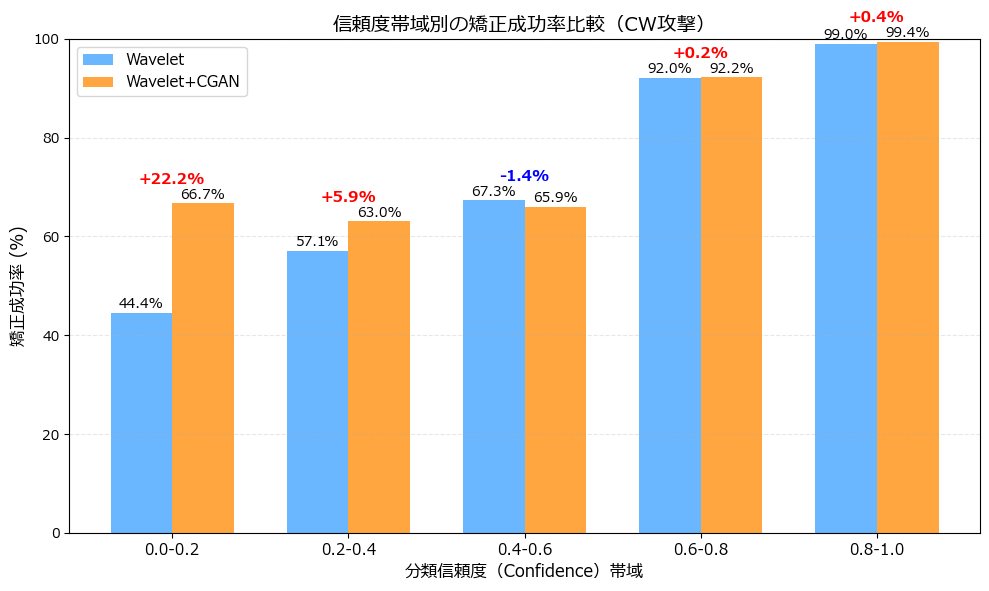

In [43]:
# =====================================================
# 📌 帯域別矯正成功率比較（Wavelet vs Wavelet+CGAN）
#     上昇幅（+◯%）表示つきバージョン
# =====================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
# [追加] 日本語フォント設定のためのインポート
import matplotlib.font_manager as fm 
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------------------------------------
# ⭐ [追加] 日本語フォント設定
# -----------------------------------------------------
# Windowsの場合の一般的な日本語フォント
# Macの場合は 'Hiragino Sans' や 'Hiragino Maru Gothic Pro' など
# Linuxの場合は 'IPAexGothic' など
FONT_NAME = "Meiryo" # または "Yu Gothic" など

# 環境にフォントが存在するかチェックし、設定
try:
    font_path = fm.findfont(fm.FontProperties(family=FONT_NAME))
    plt.rcParams["font.family"] = FONT_NAME
    print(f"✅ フォント設定: {FONT_NAME} を使用します。")
except:
    # フォントが見つからない場合は警告
    print(f"⚠️ 警告: 指定されたフォント '{FONT_NAME}' が見つかりません。デフォルト設定を試みます。")
    # フォントキャッシュをクリアして再試行する手もありますが、ここでは簡単な設定のみ
    

# -----------------------------------------------------
# ⭐ 設定
# -----------------------------------------------------
DATASET = "data2"
ATTACK  = "CW"     # ← CW でも OK

BASE = Path(r"C:\Users\sit\wavelet_CGAN\test2")
CSV = BASE / "pix2pix_restore_train_v2" / f"{DATASET}_{ATTACK}" / \
      f"compare_{DATASET}_{ATTACK}_Wavelet_CGAN.csv"

df = pd.read_csv(CSV)

# -----------------------------------------------------
# ⭐ Confidence の帯域を作成
# -----------------------------------------------------
bins = np.linspace(0, 1, 6)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(5)]

df["wavelet_bin"] = pd.cut(df["Wavelet_Confidence"], bins=bins, labels=labels)
df["cgan_bin"]    = pd.cut(df["CGAN_Confidence"],    bins=bins, labels=labels)

wavelet_rates = df.groupby("wavelet_bin")["RecoverySuccess_Wavelet"].mean().values * 100
cgan_rates    = df.groupby("cgan_bin")   ["RecoverySuccess_CGAN"].mean().values * 100

# -----------------------------------------------------
# ⭐ グラフ作成（あなたの例と同じレイアウト）
# -----------------------------------------------------
plt.figure(figsize=(10, 6))

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, wavelet_rates, width, label="Wavelet", color="#6ab7ff")
plt.bar(x + width/2, cgan_rates,    width, label="Wavelet+CGAN", color="#ffa640")

plt.title(f"信頼度帯域別の矯正成功率比較（{ATTACK}攻撃）", fontsize=14)
plt.xlabel("分類信頼度（Confidence）帯域", fontsize=12)
plt.ylabel("矯正成功率 (%)", fontsize=12)
plt.ylim(0, 100)
plt.xticks(x, labels, fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# -----------------------------------------------------
# ⭐ 上昇率（差分）を赤字で表示
# -----------------------------------------------------
for i, (w, g) in enumerate(zip(wavelet_rates, cgan_rates)):
    diff = g - w
    color = "red" if diff >= 0 else "blue"

    # Wavelet 値
    plt.text(x[i] - width/2, w + 1, f"{w:.1f}%", ha="center", fontsize=10)

    # CGAN 値
    plt.text(x[i] + width/2, g + 1, f"{g:.1f}%", ha="center", fontsize=10)

    # 改善率（+◯%）
    plt.text(x[i], max(w, g) + 4,
             f"{diff:+.1f}%", color=color,
             ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()


In [1]:
# -*- coding: utf-8 -*-
# ==========================================================
# LayerCAM / Top-3 HeatMap 統合スクリプト（Attack スクリプト完全一致版）
# ==========================================================

import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.font_manager as fm
import torchvision.transforms as T
import seaborn as sns
import random

# ==========================================================
# ★ Windows/Jupyter 用フォント設定
# ==========================================================
font_candidates = [
    "C:/Windows/Fonts/msgothic.ttc",
    "C:/Windows/Fonts/yugothic.ttf",
    "C:/Windows/Fonts/YuGothR.ttc",
]

font_path = None
for f in font_candidates:
    if Path(f).exists():
        font_path = f
        break

if font_path:
    plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
    # print("✔ 使用フォント:", font_path) # 出力抑制
else:
    # print("⚠ 日本語フォントなし → 英語フォントで実行") # 出力抑制
    pass

# ==========================================================
# ★ 予測再現性確保のための設定（シード固定とCUDNN無効化）
# ==========================================================
def set_reproducible_environment(seed_value=42):
    """すべての乱数シードを固定し、非決定的な動作を無効化する"""
    
    # 1. Pythonの組み込み乱数
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    # 2. NumPyの乱数
    np.random.seed(seed_value)
    
    # 3. PyTorchの乱数
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # 複数GPUの場合
    
    # 4. CUDAバックエンドの固定
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    print(f"✔ 予測の再現性確保のため、シードを {seed_value} に設定し、CUDNN非決定性を無効化しました。")

# スクリプトの冒頭でこの関数を実行
set_reproducible_environment(42)

# ==========================================================
# ★ 共通設定
# ==========================================================
ROOT      = Path(r"C:\Users\sit\wavelet_CGAN\test2")
dataset   = "data1"
attack    = "FGSM"
N_SAMPLES = 50
CONVERT_01_TO_MINUS11 = False # Attack スクリプトが [0,1] 保存なので False のまま

# ==========================================================
# compare CSV の位置
# ==========================================================
csv_path = ROOT / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / \
           f"compare_{dataset}_{attack}_Wavelet_CGAN.csv"

if not csv_path.exists():
    raise FileNotFoundError(f"❌ compare CSV が見つかりません:\n{csv_path}")

print("📄 Loaded CSV:", csv_path)

# ==========================================================
# 出力フォルダ（LayerCAM）
# ==========================================================
LAYER_BASE = ROOT / "layer-cam" / f"{dataset}_{attack}_pattern_fixed" # 修正版フォルダ
LAYER_BASE.mkdir(parents=True, exist_ok=True)

PATTERNS = {
    "TT": LAYER_BASE / "WaveletTrue_CGANTrue",
    "TF": LAYER_BASE / "WaveletTrue_CGANFalse",
    "FT": LAYER_BASE / "WaveletFalse_CGANTrue",
    "FF": LAYER_BASE / "WaveletFalse_CGANFalse",
}
for p in PATTERNS.values():
    p.mkdir(parents=True, exist_ok=True)

# ==========================================================
# ★ Tensor 探索関数（フォルダ固定）
# ==========================================================
CLEAN_TENSOR_DIR    = ROOT / f"{dataset}_tensor"
ATTACK_TENSOR_DIR   = ROOT / f"{dataset}_{attack}" / "tensor"
WAVELET_TENSOR_DIR  = ROOT / f"{dataset}_{attack}" / "wavelet_eval" / "wavelet_tensor"
CGAN_TENSOR_DIR     = ROOT / "pix2pix_restore_train_v2" / f"{dataset}_{attack}" / "tensor_out"

def find_clean_tensor(image_id):
    p = CLEAN_TENSOR_DIR / f"{image_id}.pt"
    return p if p.exists() else None

def find_attacked_tensor(image_id, attack):
    p = ATTACK_TENSOR_DIR / f"{image_id}.pt"
    return p if p.exists() else None

def find_wavelet_tensor(image_id, attack):
    # sampleXXXX_wavelet.pt 優先 → なければ sampleXXXX.pt
    cand1 = WAVELET_TENSOR_DIR / f"{image_id}_wavelet.pt"
    cand2 = WAVELET_TENSOR_DIR / f"{image_id}.pt"
    if cand1.exists():
        return cand1
    if cand2.exists():
        return cand2
    return None

def find_cgan_tensor(image_id, attack):
    p = CGAN_TENSOR_DIR / f"{image_id}.pt"
    if p.exists():
        return p
    # print(f"⚠ CGAN tensor not found for: {image_id}") # 出力抑制
    return None

# ==========================================================
# MobileNetV2 / NormalizeModule / Model定義
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = models.MobileNet_V2_Weights.IMAGENET1K_V1

# 元の MobileNetV2 本体
base_model = models.mobilenet_v2(weights=weights).to(device).eval()
categories = weights.meta["categories"]

# Attack スクリプトと同じ NormalizeModule
class NormalizeModule(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1, 3, 1, 1))
        self.register_buffer("std",  torch.tensor(std).view(1, 3, 1, 1))
    def forward(self, x):
        return (x - self.mean) / self.std

if "mean" in weights.meta and "std" in weights.meta:
    MEAN, STD = weights.meta["mean"], weights.meta["std"]
else:
    tinfo = weights.transforms()
    MEAN, STD = tinfo.mean, tinfo.std

norm_layer = NormalizeModule(MEAN, STD).to(device)

# ★ Attack と同じ model（Normalize → MobileNetV2）
model = nn.Sequential(norm_layer, base_model).to(device).eval()

# CAM 用に、hook を仕掛ける layer は base_model 側
target_layer = base_model.features[14]

# ==========================================================
# LayerCAM 実装
# ==========================================================
class LayerCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, m, i, o):
        self.activations = o.detach()

    def _backward_hook(self, m, gi, go):
        self.gradients = go[0].detach()

    def __call__(self, x_01):
        """
        x_01: [B,3,224,224], 値域 [0,1]
        model = NormalizeModule + MobileNetV2
        """
        x = x_01.requires_grad_(True)
        logits = self.model(x)
        tgt = logits.argmax(dim=1)
        loss = logits[torch.arange(logits.size(0)), tgt].sum()

        self.model.zero_grad()
        loss.backward(retain_graph=True)

        w = F.relu(self.gradients)
        cam = (w * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze(1).cpu()

layercam = LayerCAM(model, target_layer)

# ==========================================================
# Heatmap overlay
# ==========================================================
def overlay_cam(tensor_img, cam, alpha=0.4):
    # tensor_img: [1,3,H,W] or [3,H,W] in [0,1] / [-1,1]
    if tensor_img.ndim == 4:
        img = tensor_img[0]
    else:
        img = tensor_img

    if img.min() < 0:
        img = (img + 1) / 2

    img_np = img.detach().cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    base = (img_np * 255).astype(np.uint8)

    cam_np = cam.detach().cpu().numpy()
    import matplotlib.cm as cm
    heat = (cm.jet(cam_np)[:, :, :3] * 255).astype(np.uint8)
    base_img = Image.fromarray(base)
    heat_img = Image.fromarray(heat)

    return Image.blend(base_img, heat_img, alpha)

# ==========================================================
# CSV 読み込み & パターン分類
# ==========================================================
df = pd.read_csv(csv_path)

def determine_pattern(row):
    w = bool(row["RecoverySuccess_Wavelet"])
    c = bool(row["RecoverySuccess_CGAN"])
    return ("T" if w else "F") + ("T" if c else "F")

df["Pattern"] = df.apply(determine_pattern, axis=1)

print("\n=== Pattern counts in CSV ===")
for key in ["TT", "TF", "FT", "FF"]:
    cnt = (df["Pattern"] == key).sum()
    print(f"{key}: {cnt}")

# ==========================================================
# Tensor loader（[-1,1] → [0,1] 補正）
# ==========================================================
def tensor_from_saved_pt(path):
    t = torch.load(path, map_location=device)
    if t.ndim == 3:
        t = t.unsqueeze(0)  # (1,3,H,W)
    if CONVERT_01_TO_MINUS11 and t.max() <= 1:
        t = t * 2 - 1
    return t

def to_01(t):
    """[-1,1] の可能性を [0,1] に補正"""
    if t.min() < 0:
        return (t + 1) / 2
    return t

# ==========================================================
# ★ Attack スクリプト完全一致 Transform（LayerCAM/Top-3 共通）
# ==========================================================
# Attack スクリプトの transform_base と完全に一致させる
CORRECT_ATTACK_TRANSFORM = T.Compose([
    T.Resize((224, 224)), # Attackスクリプトでは T.Resize((224, 224)) を使用
    T.ToTensor(),
])

def preprocess_tensor(t, is_attack_tensor=False):
    """
    分類モデルへの入力テンソル（NormalizeModuleに渡す前、[0,1]）を生成する
    t: ロードされたテンソル (e.g. [1,3,H,W])
    is_attack_tensor: True の場合、Resize/Crop はスキップ
    """
    if t.ndim == 4:
        t = t.squeeze(0)
    t = t.detach().cpu()

    # [-1,1] → [0,1] 補正
    if t.min() < 0:
        t = (t + 1) / 2

    # Attack/CW のテンソルの場合、すでに224x224なので再変換しない
    if is_attack_tensor:
        # テンソルをそのまま利用（Resize/Crop/ToTensorはスキップ）
        if t.shape[1] != 224 or t.shape[2] != 224:
            print(f"⚠ Attack Tensor size mismatch: Expected 224x224, got {t.shape[1]}x{t.shape[2]}")
        x = t
    else:
        # Clean/Wavelet/CGAN の場合: PILに戻して Attack transform を適用
        
        # Tensor → PIL
        np_img = (t.permute(1,2,0).numpy() * 255).astype("uint8")
        pil = Image.fromarray(np_img)
    
        # Attack パイプラインに通す（Resize(224) → Tensor）
        x = CORRECT_ATTACK_TRANSFORM(pil) # shape: [3,224,224]

    return x.unsqueeze(0).to(device)


# ==========================================================
# ★ LayerCAM 生成ループ（最終修正適用）
# ==========================================================
for pattern_key, outdir in PATTERNS.items():
    subset = df[df["Pattern"] == pattern_key].head(N_SAMPLES)
    if len(subset) == 0:
        continue

    print(f"\n=== LayerCAM: {pattern_key} ({len(subset)} samples) ===")

    for _, row in subset.iterrows():
        image_id = str(row["ImageId"])

        # パネル情報とファイルパスを先に収集
        panel_infos = [
            ("Before", find_clean_tensor(image_id), None, False), # 予測値は再計算
            ("Attack", find_attacked_tensor(image_id, attack),  None, True),  # 予測値は再計算
            ("Wavelet", find_wavelet_tensor(image_id, attack),  None, False),
            ("CGAN", find_cgan_tensor(image_id, attack),  None, False),
        ]
        
        # 存在しないパスを除外
        valid_panels = [info for info in panel_infos if info[1] is not None]
        if len(valid_panels) != 4: continue # 4つ揃わない場合はスキップ

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f"{dataset} / {attack} / Pattern={pattern_key} / ID={image_id}", fontsize=13)

        for col, (title, path, _, is_attack_flag) in enumerate(valid_panels):
            ax_img = axes[0][col]
            ax_cam = axes[1][col]
            
            # ------------------------------
            # ① .pt ロード（テンソル化）
            # ------------------------------
            x_raw_tensor = tensor_from_saved_pt(path)
            
            # ------------------------------
            # ② テンソル前処理（Resize/Cropの有無を決定）
            # ------------------------------
            x_for_cam = preprocess_tensor(x_raw_tensor, is_attack_tensor=is_attack_flag) 

            # ------------------------------
            # ③ Top-1 予測値の再計算 (LayerCAMタイトル用)
            # ------------------------------
            # HeatMapで使用される予測値と同じ方法で再計算
            with torch.no_grad():
                preds = F.softmax(model(x_for_cam), dim=1)
            
            vals, idxs = preds.topk(1)
            top1_label = categories[int(idxs[0][0])]
            top1_conf = float(vals[0][0])
            
            # LayerCAM タイトル用のテキストを再構築
            new_text = f"{top1_label} ({top1_conf:.2f})"
            
            # ------------------------------
            # ④ CAM 計算
            # ------------------------------
            cam = layercam(x_for_cam)      # shape: (1,H,W) on CPU

            # ------------------------------
            # ⑤ 表示用画像生成
            # ------------------------------
            img_vis = x_for_cam.squeeze().detach().cpu().permute(1, 2, 0).clamp(0, 1)
            img_cam = overlay_cam(x_for_cam.cpu(), cam[0])

            ax_img.imshow(img_vis)
            ax_img.set_title(f"{title}\n{new_text}", fontsize=9) # ★ new_text を使用
            ax_img.axis("off")

            ax_cam.imshow(img_cam)
            ax_cam.set_title(f"{title} + CAM", fontsize=9)
            ax_cam.axis("off")

        # 残りの列を非表示にする
        for col in range(len(valid_panels), 4):
            axes[0][col].axis("off")
            axes[1][col].axis("off")

        # 保存
        out_path = outdir / f"{image_id}_{attack}_{pattern_key}_LayerCAM.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()

        print(f"  ✔ Saved LayerCAM → {out_path.name}")

print("\n🎉 LayerCAM（予測値統一版）完了しました")

# ==========================================================
# ★ Top-3 Ranking Shift HeatMap（修正適用済み）
# ==========================================================
# preprocess_tensor は LayerCAM と共通のものが使用される

def topk_info(tensor_pt_path, is_attack, k=3): # is_attack フラグを追加
    raw = torch.load(tensor_pt_path, map_location=device)
    # is_attack フラグを渡す
    x = preprocess_tensor(raw, is_attack_tensor=is_attack) 

    with torch.no_grad():
        preds = F.softmax(model(x), dim=1)

    vals, idxs = preds.topk(k)
    labels = [categories[int(i)] for i in idxs[0]]
    confs = [float(v) for v in vals[0]]
    ranks = list(range(1, k+1))

    return labels, confs, ranks


print("\n=== Top-3 Ranking Shift HeatMap (Attack 完全整合版) ===")

RANKING_BASE = ROOT / "ranking3_heatmap_fixed" / f"{dataset}_{attack}"
RANKING_BASE.mkdir(parents=True, exist_ok=True)

for pattern_key in ["TT", "TF", "FT", "FF"]:
    subset = df[df["Pattern"] == pattern_key].head(N_SAMPLES)
    if len(subset) == 0:
        continue

    save_dir = RANKING_BASE / pattern_key
    save_dir.mkdir(parents=True, exist_ok=True)

    for _, row in subset.iterrows():
        image_id = str(row["ImageId"])
        clean_p = find_clean_tensor(image_id)
        adv_p   = find_attacked_tensor(image_id, attack)
        wav_p   = find_wavelet_tensor(image_id, attack)
        cgan_p  = find_cgan_tensor(image_id, attack)

        if None in [clean_p, adv_p, wav_p, cgan_p]:
            continue

        # ★ is_attack フラグの適用
        b_lab, b_conf, b_rank = topk_info(clean_p, is_attack=False)
        a_lab, a_conf, a_rank = topk_info(adv_p, is_attack=True) # ★ AttackテンソルはTrue
        w_lab, w_conf, w_rank = topk_info(wav_p, is_attack=False)
        g_lab, g_conf, g_rank = topk_info(cgan_p, is_attack=False)


        union_labels = list(dict.fromkeys(b_lab + a_lab + w_lab + g_lab))
        stages = ["Before", "Attack", "Wavelet", "CGAN"]

        data_conf = []
        data_rank = []

        # ... (HeatMap生成ロジックは変更なし) ...
        for label in union_labels:
            conf_row = []
            rank_row = []

            for labs, confs, ranks in [
                (b_lab, b_conf, b_rank),
                (a_lab, a_conf, a_rank),
                (w_lab, w_conf, w_rank),
                (g_lab, g_conf, g_rank),
            ]:
                if label in labs:
                    idx = labs.index(label)
                    conf_row.append(confs[idx])
                    rank_row.append(ranks[idx])
                else:
                    conf_row.append(0.0)
                    rank_row.append(None)

            data_conf.append(conf_row)

            cell_row = []
            for r, c in zip(rank_row, conf_row):
                if r is None or c == 0.0:
                    cell_row.append("")
                else:
                    cell_row.append(f"{r} ({c:.2f})")
            data_rank.append(cell_row)

        filtered_labels, filtered_conf, filtered_rank = [], [], []
        for lbl, conf_row, rank_row in zip(union_labels, data_conf, data_rank):
            if any(c > 0 for c in conf_row):
                filtered_labels.append(lbl)
                filtered_conf.append(conf_row)
                filtered_rank.append(rank_row)

        if len(filtered_labels) == 0:
            continue

        plt.figure(figsize=(6, 0.5 * len(filtered_labels) + 2))
        sns.heatmap(
            filtered_conf,
            annot=filtered_rank,
            fmt="",
            cmap="viridis",
            xticklabels=stages,
            yticklabels=filtered_labels,
            vmin=0, vmax=1
        )

        plt.title(
            f"{dataset}/{attack}/{pattern_key}/{image_id}\nTop-3 Ranking Shift HeatMap (Fixed Transform)"
        )
        plt.tight_layout()

        out_png = save_dir / f"{image_id}_{pattern_key}_top3_ranking_heatmap.png"
        plt.savefig(out_png, dpi=200)
        plt.close()

        print(f"✔ Saved: {out_png.name}")

print("\n🎉 Top-3 HeatMap（Attack パイプライン完全一致版）完了しました")

✔ 予測の再現性確保のため、シードを 42 に設定し、CUDNN非決定性を無効化しました。
📄 Loaded CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_train_v2\data1_FGSM\compare_data1_FGSM_Wavelet_CGAN.csv

=== Pattern counts in CSV ===
TT: 598
TF: 16
FT: 299
FF: 87

=== LayerCAM: TT (50 samples) ===
  ✔ Saved LayerCAM → sample0003_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0004_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0007_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0008_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0010_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0011_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0012_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0013_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0014_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0019_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0022_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0023_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0024_FGSM_TT_LayerCAM.png
  ✔ Saved LayerCAM → sample0025_FGSM_TT_LayerCAM.pn

In [4]:
import pandas as pd
from pathlib import Path

# ==========================================================
# ★ 共通設定
# ==========================================================
# 環境に合わせてROOTパスを設定してください
# 例: C:\Users\sit\wavelet_CGAN\test2
ROOT = Path(r"C:\Users\sit\wavelet_CGAN\test2") 
DATASET = "data1"
TOTAL_SAMPLES = 1000  # データセットの全画像数に合わせて変更してください (例として1000を設定)

# ==========================================================
# CSVファイルのパス定義
# ==========================================================
# pix2pix_restore_train_v2/{dataset}_{attack}/compare_{dataset}_{attack}_Wavelet_CGAN.csv
BASE_DIR = ROOT / "pix2pix_restore_train_v2"

CSV_PATHS = {
    "CW": BASE_DIR / f"{DATASET}_CW" / f"compare_{DATASET}_CW_Wavelet_CGAN.csv",
    "FGSM": BASE_DIR / f"{DATASET}_FGSM" / f"compare_{DATASET}_FGSM_Wavelet_CGAN.csv",
}

# ==========================================================
# ★ 関数: FFパターン画像IDの抽出
# ==========================================================
def get_ff_samples(attack_name, csv_path):
    """CSVを読み込み、Wavelet/CGANの両方で矯正失敗(FF)したImageIdのセットを返す"""
    if not csv_path.exists():
        print(f"❌ {attack_name} のCSVが見つかりません: {csv_path}")
        return set()
    
    df = pd.read_csv(csv_path)
    
    # --- 失敗 (FF) の定義 ---
    # RecoverySuccess_Wavelet と RecoverySuccess_CGAN が両方 False
    ff_df = df[
        (df['RecoverySuccess_Wavelet'] == False) & 
        (df['RecoverySuccess_CGAN'] == False)
    ]
    
    ff_set = set(ff_df['ImageId'].tolist())
    print(f"✔ {attack_name} 攻撃の FF 画像数: {len(ff_set)} / {len(df)}")
    return ff_set

# ==========================================================
# ★ メイン処理: FFパターンの一致率計算
# ==========================================================

print("=== 矯正失敗画像 (FFパターン) の一致率計算 ===")

# 1. FFパターン画像IDの抽出
ff_cw_set = get_ff_samples("CW", CSV_PATHS["CW"])
ff_fgsm_set = get_ff_samples("FGSM", CSV_PATHS["FGSM"])

if not ff_cw_set or not ff_fgsm_set:
    print("\n計算に必要なデータが不足しています。パスとファイル名を確認してください。")
else:
    # 2. 共通集合の計算
    common_ff_set = ff_cw_set.intersection(ff_fgsm_set)
    
    common_count = len(common_ff_set)
    cw_count = len(ff_cw_set)
    fgsm_count = len(ff_fgsm_set)
    
    print("\n--- 計算結果 ---")
    print(f"全画像数 (N): {TOTAL_SAMPLES}")
    print(f"共通失敗画像数 (|FF_CW ∩ FF_FGSM|): {common_count}")
    
    
    # 3. (A) 攻撃手法を問わない「共通失敗率」
    common_failure_rate = common_count / TOTAL_SAMPLES
    print(f"\n(A) 全画像に対する共通失敗率: {common_failure_rate:.4f} ({common_count} / {TOTAL_SAMPLES})")

    # 4. (B) (C) 一致率の計算
    
    # (B) CW失敗群におけるFGSM失敗との一致率
    if cw_count > 0:
        match_rate_cw_base = common_count / cw_count
        print(f"(B) CW失敗群基準の一致率 (|FF_CW ∩ FF_FGSM| / |FF_CW|): {match_rate_cw_base:.4f} ({common_count} / {cw_count})")
    else:
        print("(B) CW失敗画像がないため、CW基準の一致率は計算できません。")

    # (C) FGSM失敗群におけるCW失敗との一致率
    if fgsm_count > 0:
        match_rate_fgsm_base = common_count / fgsm_count
        print(f"(C) FGSM失敗群基準の一致率 (|FF_CW ∩ FF_FGSM| / |FF_FGSM|): {match_rate_fgsm_base:.4f} ({common_count} / {fgsm_count})")
    else:
        print("(C) FGSM失敗画像がないため、FGSM基準の一致率は計算できません。")
        
    print("\n🎉 計算完了")

=== 矯正失敗画像 (FFパターン) の一致率計算 ===
✔ CW 攻撃の FF 画像数: 15 / 1000
✔ FGSM 攻撃の FF 画像数: 87 / 1000

--- 計算結果 ---
全画像数 (N): 1000
共通失敗画像数 (|FF_CW ∩ FF_FGSM|): 15

(A) 全画像に対する共通失敗率: 0.0150 (15 / 1000)
(B) CW失敗群基準の一致率 (|FF_CW ∩ FF_FGSM| / |FF_CW|): 1.0000 (15 / 15)
(C) FGSM失敗群基準の一致率 (|FF_CW ∩ FF_FGSM| / |FF_FGSM|): 0.1724 (15 / 87)

🎉 計算完了


In [ ]:
未攻撃画像の矯正実験

In [15]:
# ==========================================================
# Wavelet分類回復（未攻撃画像のみを自動処理）
# data1_tensor, data2_tensor のみ処理
# ==========================================================

import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import pywt
from pathlib import Path
from tqdm import tqdm


# ==========================================================
# === Waveletノイズ除去 ===
# ==========================================================
def wavelet_denoise(img_tensor, wavelet='haar', level=1, threshold=0.07):
    """
    テンソル化された画像に2次元離散ウェーブレット変換 (DWT) を適用し、
    高周波数成分（ノイズ）を閾値処理して除去し、再構成します。
    """
    img_tensor = img_tensor.detach().cpu()
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)

    img_np = img_tensor.numpy()
    denoised = []

    for b in range(img_np.shape[0]):
        out_c = []
        for c in range(img_np[b].shape[0]):
            # 2D-DWTによる多重解像度分解 (MRA)
            coeffs = pywt.wavedec2(img_np[b, c], wavelet, level=level)
            cA, cD = coeffs[0], coeffs[1:]  # cA:近似係数, cD:詳細係数リスト

            cD_new = []
            for (cH, cV, cD_) in cD:
                # 詳細係数（ノイズ成分を多く含む）を閾値処理
                # ここでは閾値を最大絶対値の0.07倍に設定（デフォルト値）
                cH = pywt.threshold(cH, threshold*np.max(np.abs(cH)))
                cV = pywt.threshold(cV, threshold*np.max(np.abs(cV)))
                cD_ = pywt.threshold(cD_, threshold*np.max(np.abs(cD_)))
                cD_new.append((cH, cV, cD_))
            
            # 再構成
            coeffs_new = [cA] + cD_new
            rec = pywt.waverec2(coeffs_new, wavelet)
            
            # 画像サイズを調整（ウェーブレット変換後のサイズ不一致を防ぐ）
            rec = rec[:img_np.shape[2], :img_np.shape[3]]
            out_c.append(rec)
        denoised.append(np.stack(out_c))

    # 

    return torch.tensor(np.stack(denoised)).float().clamp(0,1)


# ==========================================================
# === MobileNetV2 ロード & 予測 ===
# ==========================================================
def load_model(device):
    """MobileNetV2モデルと標準化関数をロードします。"""
    model = models.mobilenet_v2(
        weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
    ).to(device).eval()

    # ImageNetで学習されたモデルの標準化パラメータ
    normalize = T.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
    return model, normalize


def predict(model, img_tensor, normalize):
    """分類予測を実行し、インデックスと信頼度を返します。"""
    with torch.no_grad():
        preds = F.softmax(model(normalize(img_tensor)), dim=1)
        conf, idx = preds.max(1)
        return int(idx.item()), float(conf.item())


# ==========================================================
# === Wavelet処理メイン (未攻撃画像用) ===
# data1_tensor, data2_tensor のように、テンソルが直下にあるフォルダを処理
# ==========================================================
def process_wavelet_original_folder(folder):
    """
    指定されたフォルダ内の未攻撃画像テンソルに対し、ウェーブレット処理と分類を実行します。
    この関数は、引数で渡されたフォルダ自体をテンソルディレクトリとして扱います。
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder = Path(folder) # 例: Path("C:\Users\sit\wavelet_CGAN\test2\data1_tensor")
    
    tensor_dir = folder
    if not tensor_dir.exists():
        print(f"[SKIP] テンソルフォルダが無いのでスキップ → {folder}")
        return

    print(f"\n=============================================")
    print(f"▶ Wavelet処理開始: {folder.name} (Original)")
    print("=============================================")

    # 出力フォルダを親ディレクトリの "wavelet_normal" 以下に作成
    output_root = folder.parent / f"{folder.name}_wavelet_normal"
    out_tensor_dir = output_root / "wavelet_tensor"
    out_image_dir = output_root / "wavelet_images"
    output_root.mkdir(parents=True, exist_ok=True)
    out_tensor_dir.mkdir(parents=True, exist_ok=True)
    out_image_dir.mkdir(parents=True, exist_ok=True)

    model, normalize = load_model(device)
    results = []

    for fname in tqdm(sorted(os.listdir(tensor_dir))):
        if not fname.endswith(".pt"):
            continue

        name = fname.replace(".pt", "")
        # テンソルをロード
        t = torch.load(tensor_dir / fname)

        if t.ndim == 3:
            t = t.unsqueeze(0)

        # Wavelet処理
        w = wavelet_denoise(t)

        # GPUへ転送
        w_gpu = w.to(device)

        # 分類予測
        label_id, conf = predict(model, w_gpu, normalize)
        label_name = models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"][label_id]

        # 結果を保存
        torch.save(w.cpu(), out_tensor_dir / f"{name}_wavelet.pt")
        save_image(w.cpu(), out_image_dir / f"{name}_wavelet.png")

        results.append({
            "ImageId": name,
            "Wavelet_Label": label_name,
            "Wavelet_Confidence": round(conf, 6),
        })

    out_csv = output_root / f"{folder.name}_Original_Wavelet_class_results.csv"
    pd.DataFrame(results).to_csv(out_csv, index=False, encoding="utf-8-sig")

    print(f"➡ 完了: {out_csv}")


# ==========================================================
# ★ 実行本体 ★
# ==========================================================

# --- データセットの設定 ---
datasets = ["data1", "data2"]
base_root = r"C:\Users\sit\wavelet_CGAN\test2"


# === 1. 未攻撃画像フォルダの処理 (Original Data: *_tensor) ===
print("--- 🌟 未攻撃画像 (Original Data) の処理を開始 🌟 ---")
for ds in datasets:
    # 未攻撃画像テンソルフォルダのパスを作成 (例: C:\Users\sit\wavelet_CGAN\test2\data1_tensor)
    original_tensor_folder = Path(base_root) / f"{ds}_tensor"
    
    # 未攻撃画像専用の処理関数を呼び出し
    process_wavelet_original_folder(original_tensor_folder)
    

print("\n✅ 全ての処理が完了しました。")

--- 🌟 未攻撃画像 (Original Data) の処理を開始 🌟 ---

▶ Wavelet処理開始: data1_tensor (Original)


100%|██████████| 1000/1000 [00:29<00:00, 33.98it/s]


➡ 完了: C:\Users\sit\wavelet_CGAN\test2\data1_tensor_wavelet_normal\data1_tensor_Original_Wavelet_class_results.csv

▶ Wavelet処理開始: data2_tensor (Original)


100%|██████████| 1000/1000 [00:29<00:00, 34.33it/s]

➡ 完了: C:\Users\sit\wavelet_CGAN\test2\data2_tensor_wavelet_normal\data2_tensor_Original_Wavelet_class_results.csv

✅ 全ての処理が完了しました。


In [38]:
# -*- coding: utf-8 -*-
# ==========================================================
# Wavelet＋CGAN復元＋4段階比較＆成功率判定
# （旧仕様：tensor_out 保存版）
# ==========================================================

import os
import sys
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from torchvision import models
from torchvision.utils import save_image
from torch import nn
from tqdm import tqdm
from shutil import copy2

# ========= 0) 再現性（任意） =========
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ========= 1) 共通設定 =========
#BASE = Path(r"C:\Users\sit\wavelet_CGAN\test2")
BASE = Path(r"C:\Users\sit\wavelet_CGAN\test2")


DATASETS = ["data1", "data2"]
ATTACKS  = ["FGSM","CW"]      # ["FGSM", "CW"] にしてもOK
LEGACY_PREPROCESS = True

#WEIGHT_PATH = BASE / "GAN_train" /"pix2pix_train" / "weights" / "gen_weights_epoch300.pth"
WEIGHT_PATH = BASE /"GAN_train"/ "pix2pix_train" / "weights" / "gen_weights_epoch700.pth"
# ========= 2) 存在チェック =========
def _must_exist(p: Path, hint: str = ""):
    if not p.exists():
        print(f"\n[ERROR] Not found: {p}")
        if hint:
            print("Hint:", hint)
        sys.exit(1)

# ========= 3) MobileNetV2 =========
def load_classifier(device):
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
    model = models.mobilenet_v2(weights=weights).to(device).eval()
    categories = weights.meta["categories"]

    if LEGACY_PREPROCESS:
        preprocess = weights.transforms()   # Resize/Crop 含む
    else:
        from torchvision import transforms as T
        preprocess = T.Normalize(mean=weights.meta["mean"], std=weights.meta["std"])

    return model, preprocess, categories

# ========= 4) CGAN Generator（旧仕様）=========
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        self.encoder = nn.Sequential(
            self.block(in_channels, features, normalize=False),
            self.block(features, features * 2),
            self.block(features * 2, features * 4),
            self.block(features * 4, features * 8),
            self.block(features * 8, features * 8),
        )

        self.decoder = nn.ModuleList([
            self.upblock(features * 8,     features * 8),
            self.upblock(features * 8 * 2, features * 4),
            self.upblock(features * 4 * 2, features * 2),
            self.upblock(features * 2 * 2, features),
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh(),
        ])

    def block(self, in_c, out_c, normalize=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def upblock(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        skips = []

        # Encoder
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)

        x = skips[-1]
        skips = skips[:-1][::-1]

        # Decoder with skip connections
        for i in range(4):
            x = self.decoder[i](x)
            x = torch.cat([x, skips[i]], dim=1)

        # Final conv
        x = self.decoder[4](x)

        # Tanh
        return self.decoder[5](x)


# (前略：UNetGeneratorまで同じ)

# ========= 5) データセット×攻撃ごとに処理 (攻撃済み画像用) =========
# (元の process_dataset_attack 関数はそのまま残す)
def process_dataset_attack(dataset: str, attack_type: str):
    # ... (元のコードと同じ) ...
    pass # 便宜上のプレースホルダー

# ==========================================================
# === 5-b) 未攻撃画像（Wavelet後）のCGAN評価処理 ===
# ==========================================================
def process_original_cgan_eval(dataset: str):

    print("\n" + "=" * 60)
    print(f"▶ 開始: {dataset} / Original Wavelet + CGAN Eval")
    print("=" * 60 + "\n")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- パス設定 -----
    # 入力パス: ウェーブレット処理済みの未攻撃画像テンソル
    wavelet_eval_root = BASE / f"{dataset}_tensor_wavelet_normal"
    tensor_dir        = wavelet_eval_root / "wavelet_tensor"
    wavelet_csv       = wavelet_eval_root / f"{dataset}_tensor_Original_Wavelet_class_results.csv"

    # 出力パス: CGAN復元結果
    cgan_out_dir = BASE / "pix2pix_restore_original" / dataset
    cgan_out_dir.mkdir(parents=True, exist_ok=True)
    
    # ★ CGAN Tensor 保存フォルダ
    tensor_out_dir = cgan_out_dir / "tensor_out"
    tensor_out_dir.mkdir(parents=True, exist_ok=True)

    cgan_csv       = cgan_out_dir / f"pix2pix_class_results_{dataset}_Original.csv"
    merged_csv     = cgan_out_dir / f"compare_{dataset}_Original_Wavelet_CGAN.csv"

    # 比較用（元の分類結果）
    clean_dir    = BASE / dataset
    before_csv   = clean_dir / "clean_dataset_labels.csv"
    
    # CGAN復元失敗画像保存先
    cgan_failed_dir = BASE / "cgan_restore_failed_original" / dataset
    cgan_failed_dir.mkdir(parents=True, exist_ok=True)
    failed_list_csv = cgan_out_dir / f"failed_lists_{dataset}_Original.csv"

    # チェック
    _must_exist(before_csv)
    _must_exist(wavelet_csv) # 先にWavelet処理が実行されている前提
    _must_exist(tensor_dir)
    _must_exist(WEIGHT_PATH)

    # ========= 5-1) CGAN復元＋分類 (元の関数から流用) =========
    def restore_and_classify():
        # ... (process_dataset_attack 内の restore_and_classify と同じ内容) ...
        # (ただし、ファイル名から "_wavelet" を削除するロジックは必要)
        
        gen = UNetGenerator().to(device)
        gen.load_state_dict(torch.load(WEIGHT_PATH, map_location=device))
        gen.eval()

        clf, preprocess, categories = load_classifier(device)
        results = []

        print(f"\n=== CGAN推論＋分類 ({dataset}/Original) ===\n")

        with torch.no_grad():
            for fname in tqdm(sorted(os.listdir(tensor_dir))):
                if not fname.endswith(".pt"):
                    continue

                t = torch.load(tensor_dir / fname, map_location=device)
                if t.ndim == 3:
                    t = t.unsqueeze(0)

                # 正規化 (-1 to 1)
                if t.min() >= 0 and t.max() <= 1:
                    t_in = (t - 0.5) / 0.5
                else:
                    t_in = t

                restored = gen(t_in.to(device))
                restored_01 = (restored * 0.5 + 0.5).clamp(0, 1)

                base = Path(fname).stem.replace("_wavelet", "")

                # ★ CGAN 出力 Tensor 保存
                torch.save(restored.cpu(), tensor_out_dir / f"{base}.pt")

                # PNG 保存
                out_png = cgan_out_dir / f"{base}_Original_restored.png"
                save_image(restored_01.cpu(), out_png)

                # 分類
                x = restored_01.squeeze(0).cpu()
                x = preprocess(x).unsqueeze(0).to(device)
                preds = F.softmax(clf(x), dim=1)

                conf, idx = preds.max(1)
                label = categories[int(idx)]

                results.append({
                    "ImageId": base,
                    "CGAN_Label": label,
                    "CGAN_Confidence": float(conf),
                })

        pd.DataFrame(results).to_csv(cgan_csv, index=False, encoding="utf-8-sig")
        print(f"✔ CGAN分類結果CSV: {cgan_csv}")
        print(f"✔ Tensor保存先: {tensor_out_dir}")

    # ========= 5-2) 3段階CSV統合と評価 =========
    def merge_and_evaluate():

        print(f"\n=== 3段階CSV統合 ({dataset}/Original) ===\n")

        df_b = pd.read_csv(before_csv)  # (1) 元画像
        df_w = pd.read_csv(wavelet_csv) # (2) Wavelet後
        df_g = pd.read_csv(cgan_csv)    # (3) CGAN復元後

        # ImageIdの準備
        df_b["ImageId"] = df_b["image"].apply(lambda x: Path(str(x)).stem)
        df_w["ImageId"] = df_w["ImageId"].astype(str)
        df_g["ImageId"] = df_g["ImageId"].astype(str)

        df_b = df_b.rename(columns={"label_name":"label_name_Original",
                                     "confidence":"confidence_Original"})
        df_w = df_w.rename(columns={"Wavelet_Label":"label_name_Wavelet", 
                                     "Wavelet_Confidence":"confidence_Wavelet"})

        # 統合
        df = (df_b[["ImageId", "label_name_Original", "confidence_Original"]]
                 .merge(df_w, on="ImageId", how="inner")
                 .merge(df_g, on="ImageId", how="left"))

        # 復元成功判定: 元のラベルと同じか
        df["Wavelet_Preserved"] = df["label_name_Original"] == df["label_name_Wavelet"]
        df["CGAN_Preserved"]    = df["label_name_Original"] == df["CGAN_Label"]

        df.to_csv(merged_csv, index=False, encoding="utf-8-sig")
        print(f"✔ 統合CSV: {merged_csv}")

        # 統計
        total = len(df)
        w_ok = int(df["Wavelet_Preserved"].sum())
        g_ok = int(df["CGAN_Preserved"].sum())
        pct = lambda n: (n/total*100.0) if total else 0.0

        print("\n=== 統計 ===")
        print(f"総数: {total}")
        print(f"Wavelet処理後の分類保持率: {w_ok}/{total} ({pct(w_ok):.2f}%)")
        print(f"Wavelet + CGAN後の分類保持率: {g_ok}/{total} ({pct(g_ok):.2f}%)")
        
        # 失敗画像保存は今回はCGANのみ
        cgan_failed = df[df["CGAN_Preserved"] == False]
        for _, row in cgan_failed.iterrows():
            img_id = row["ImageId"]
            src = cgan_out_dir / f"{img_id}_Original_restored.png"
            if src.exists():
                copy2(src, cgan_failed_dir / src.name)

        if len(cgan_failed) > 0:
            cgan_failed.to_csv(failed_list_csv, index=False, encoding="utf-8-sig")
            print(f"📝 CGAN復元失敗一覧CSV: {failed_list_csv}")

    # ===== 実行 =====
    restore_and_classify()
    merge_and_evaluate()


# ========= 6) 一括実行 (メインの修正) =========
if __name__ == "__main__":

    _must_exist(WEIGHT_PATH)

    # 攻撃済み画像処理は不要なので削除し、未攻撃画像処理のみ実行
    for ds in DATASETS:
        process_original_cgan_eval(ds)

    print("\n=== Wavelet＋CGAN 全処理完了 ===\n")



▶ 開始: data1 / Original Wavelet + CGAN Eval


=== CGAN推論＋分類 (data1/Original) ===



100%|██████████| 1000/1000 [00:48<00:00, 20.81it/s]


✔ CGAN分類結果CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data1\pix2pix_class_results_data1_Original.csv
✔ Tensor保存先: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data1\tensor_out

=== 3段階CSV統合 (data1/Original) ===

✔ 統合CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data1\compare_data1_Original_Wavelet_CGAN.csv

=== 統計 ===
総数: 1000
Wavelet処理後の分類保持率: 965/1000 (96.50%)
Wavelet + CGAN後の分類保持率: 955/1000 (95.50%)
📝 CGAN復元失敗一覧CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data1\failed_lists_data1_Original.csv

▶ 開始: data2 / Original Wavelet + CGAN Eval


=== CGAN推論＋分類 (data2/Original) ===



100%|██████████| 1000/1000 [00:45<00:00, 21.97it/s]

✔ CGAN分類結果CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data2\pix2pix_class_results_data2_Original.csv
✔ Tensor保存先: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data2\tensor_out

=== 3段階CSV統合 (data2/Original) ===

✔ 統合CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data2\compare_data2_Original_Wavelet_CGAN.csv

=== 統計 ===
総数: 1000
Wavelet処理後の分類保持率: 979/1000 (97.90%)
Wavelet + CGAN後の分類保持率: 958/1000 (95.80%)
📝 CGAN復元失敗一覧CSV: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_original\data2\failed_lists_data2_Original.csv

=== Wavelet＋CGAN 全処理完了 ===



In [ ]:
word出力(論文用)

In [3]:
#実験１攻撃結果
import pandas as pd
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from torchvision import models
from pathlib import Path
import os
import sys
import numpy as np # np.float64などの型チェックのためにインポート

# ==========================================================
# 🌟 設定箇所 🌟
# ==========================================================

# ベースディレクトリ (攻撃結果のCSVファイルを含む親フォルダの親フォルダ)
BASE_DIR = Path(r"C:\Users\sit\wavelet_CGAN\test2")
#BASE_DIR = Path(r"C:\Users\sit\wavelet_CGAN\test2\GAN_train") 訓練用

# 処理したいデータセット名と攻撃タイプの組み合わせを指定
# 例: [('data3', 'FGSM'), ('data1', 'CW')]
DATA_SELECTION = [
    # 敵対的サンプルとして生成したデータセットと攻撃の組み合わせ
    ('data1', 'FGSM'),  # data3/data3_FGSM/FGSM_Results.csv を処理
    ('data1', 'CW'),    # data1/data1_CW/CW_Results.csv を処理
]

# ==========================================================
# 共通設定 & ユーティリティ
# ==========================================================

# ImageNetクラス辞書を取得 (C&W処理で使用)
try:
    imagenet_classes = models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"]
    id_to_name = {i: name for i, name in enumerate(imagenet_classes)}
except Exception as e:
    print(f"⚠️ 警告: MobileNetV2のクラスカテゴリのロードに失敗しました。クラス名変換はスキップされます。エラー: {e}")
    id_to_name = {}

# クラス名（class_xxx → 実名）変換関数 (C&W処理で使用)
def convert_class_name(value):
    """クラスID文字列 ('class_xxx') を対応するImageNetクラス名に変換します。"""
    if isinstance(value, str) and value.startswith("class_"):
        try:
            idx = int(value.split("_")[1])
            return id_to_name.get(idx, value)
        except Exception:
            return value
    return value

# ==========================================================
# メイン処理関数: Word表作成
# ==========================================================

def create_word_table(csv_path: Path, attack_type: str, dataset_name: str, class_conversion: bool = False):
    """
    指定されたCSVファイルからデータを読み込み、Word文書として整形して保存します。
    """
    
    print(f"\n--- 処理開始: {dataset_name} / {attack_type} ---")
    
    # 存在チェック
    if not csv_path.exists():
        print(f"❌ エラー: CSVファイルが見つかりません: {csv_path}")
        return

    df = pd.read_csv(csv_path)

    # C&Wの場合、クラス名変換と列名/桁数調整
    if attack_type == "CW":
        if class_conversion and id_to_name:
            df["Original_label_name"] = df["Original_label_name"].apply(convert_class_name)
            df["Advs_label_name"] = df["Advs_label_name"].apply(convert_class_name)
        
        columns = [
            "Original_label_name", "Original_confidence",
            "Advs_label_name", "Advs_confidence",
            "L2_Distance"
        ]
        col_names = ["入力画像ラベル", "confidence", "敵対的画像ラベル", "confidence(敵対的)", "L2距離"]
        col_widths = [Inches(1.7), Inches(1.0), Inches(1.7), Inches(1.0), Inches(0.8)]
        df["L2_Distance"] = df["L2_Distance"].round(6)
        
    # FGSMの場合
    elif attack_type == "FGSM":
        columns = [
            "Original_label_name", "Original_confidence",
            "Advs_label_name", "Advs_confidence",
            "Advs_eps"
        ]
        col_names = ["入力画像ラベル", "confidence", "敵対的画像ラベル", "confidence(敵対的)", "SucEps"]
        col_widths = [Inches(1.5), Inches(1.0), Inches(1.5), Inches(1.0), Inches(0.8)]

    else:
        print(f"❌ エラー: 未知の攻撃タイプ {attack_type}")
        return

    df_show = df[columns].copy()

    # 先頭100枚のみ抽出
    df_show = df_show.head(100)

    # 桁数調整
    df_show["Original_confidence"] = df_show["Original_confidence"].round(6)
    df_show["Advs_confidence"] = df_show["Advs_confidence"].round(6)

    # 日本語列名を設定
    df_show.columns = col_names

    # === Word文書作成 ===
    doc = Document()
    doc.add_heading(f"攻撃結果表（{attack_type} / {dataset_name}）", level=1)
    doc.add_paragraph(f"{dataset_name}に対する{attack_type}攻撃後の分類結果（先頭{len(df_show)}枚）を示す。")

    # 分割設定
    interval = 20 
    
    # === 表を出力 ===
    for start in range(0, len(df_show), interval):
        subset = df_show.iloc[start:start + interval]
        table = doc.add_table(rows=1, cols=len(df_show.columns))
        table.style = 'Table Grid'

        # --- ヘッダー行 ---
        hdr_cells = table.rows[0].cells
        for i, col_name in enumerate(df_show.columns):
            p = hdr_cells[i].paragraphs[0]
            run = p.add_run(col_name)
            run.bold = True
            run.font.name = '游明朝'
            run.font.size = Pt(10.5)
            p.alignment = WD_ALIGN_PARAGRAPH.CENTER

        # --- データ行 ---
        for _, row in subset.iterrows():
            row_cells = table.add_row().cells
            for i, val in enumerate(row):
                # float型の場合、小数点固定フォーマットを適用
                if isinstance(val, (float, np.float64, np.float32)):
                    text = f"{val:.6f}"
                else:
                    text = str(val)
                
                p = row_cells[i].paragraphs[0]
                run = p.add_run(text)
                run.font.name = '游明朝'
                run.font.size = Pt(10.5)
                p.alignment = WD_ALIGN_PARAGRAPH.CENTER

        # --- 列幅設定 ---
        for row in table.rows:
            for i, width in enumerate(col_widths):
                row.cells[i].width = width

        # --- 表間にスペースを追加 ---
        doc.add_paragraph("")

    # === Wordファイル保存 ===
    output_dir = csv_path.parent
    save_file_name = f"{dataset_name}_{attack_type}_Table_YuMincho_{len(df_show)}.docx"
    save_path = output_dir / save_file_name
    
    doc.save(save_path)

    print(f"✅ {dataset_name}/{attack_type} 結果をWord出力しました：{save_path}")


# ==========================================================
# 実行本体
# ==========================================================
if __name__ == "__main__":
    print(f"ベースディレクトリ: {BASE_DIR}")
    print(f"処理対象: {DATA_SELECTION}")

    for dataset_name, attack_type in DATA_SELECTION:
        # CSVファイルのパスを動的に構築
        # 例: C:\Users\sit\wavelet_CGAN\test2 / data3_FGSM / FGSM_Results.csv
        
        # フォルダ名は {dataset_name}_{attack_type} の形式を想定
        target_folder = BASE_DIR / f"{dataset_name}_{attack_type}"
        csv_file_name = f"{attack_type}_Results.csv"
        csv_path = target_folder / csv_file_name
        
        # C&Wの場合のみクラス名変換をTrueにする
        should_convert = (attack_type == "CW") 

        create_word_table(csv_path, attack_type, dataset_name, class_conversion=should_convert)

    print("\n=== 全ての処理が完了しました。 ===")

ベースディレクトリ: C:\Users\sit\wavelet_CGAN\test2
処理対象: [('data1', 'FGSM'), ('data1', 'CW')]

--- 処理開始: data1 / FGSM ---
✅ data1/FGSM 結果をWord出力しました：C:\Users\sit\wavelet_CGAN\test2\data1_FGSM\data1_FGSM_Table_YuMincho_100.docx

--- 処理開始: data1 / CW ---
❌ エラー: CSVファイルが見つかりません: C:\Users\sit\wavelet_CGAN\test2\data1_CW\CW_Results.csv

=== 全ての処理が完了しました。 ===


In [2]:
#実験２　wavelet+CGAN 一覧表
import pandas as pd
from torchvision import models
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from pathlib import Path
import numpy as np

# ==========================================================
# 🌟 設定と共通パス 🌟
# ==========================================================

# ベースディレクトリ (C:\Users\sit\wavelet_CGAN\test2 の親フォルダ)
BASE_DIR = Path(r"C:\Users\sit\wavelet_CGAN")

# 出力行数
NUM_ROWS = 20  # 出力件数

# 処理するデータセット、攻撃タイプ、ファイル名情報の設定
CONFIGS = [
    ('data2', 'CW', Path("test2/pix2pix_restore_train_v2"), 'compare_'),
]

# ==========================================================
# 共通処理とユーティリティ
# ==========================================================

# ImageNetクラス名リストを取得
try:
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
    imagenet_labels = weights.meta["categories"]
except Exception as e:
    print(f"⚠️ 警告: ImageNetラベルのロードに失敗しました。クラス名変換は行われません。エラー: {e}")
    imagenet_labels = []

# === class_XXX → ラベル名に変換関数 ===
def convert_class_to_label(x):
    """クラスID文字列を対応するImageNetクラス名に変換します。"""
    if pd.isna(x) or not imagenet_labels:
        return x
    if isinstance(x, str) and x.startswith("class_"):
        try:
            idx = int(x.replace("class_", "").strip())
            if 0 <= idx < len(imagenet_labels):
                 return imagenet_labels[idx]
            else:
                 return x
        except ValueError:
            return x
    return x

# === 実行関数 ===
def process_and_output_4stage(dataset: str, attack: str, sub_path: Path, prefix: str):
    """4段階の分類結果を比較し、Wordに出力します。"""
    
    csv_filename = f"{prefix}{dataset}_{attack}_Wavelet_CGAN.csv"
    csv_dir = BASE_DIR / sub_path / f"{dataset}_{attack}"
    csv_path = csv_dir / csv_filename
    output_docx = csv_dir / f"{dataset}_{attack}_4Stage_compare_top{NUM_ROWS}.docx"

    print(f"\n--- 処理開始: {dataset}/{attack} (4段階比較) ---")
    print(f"CSVを探しています: {csv_path}")

    if not csv_path.exists():
        print(f"❌ エラー: CSVファイルが見つかりません: {csv_path}")
        return

    # --- CSV読み込み ---
    df = pd.read_csv(csv_path)

    # --- ラベル変換 (全段階のラベル列を対象) ---
    for col in ["label_name_before", "label_name_after", "Wavelet_Label", "CGAN_Label"]:
        if col in df.columns:
            df[col] = df[col].apply(convert_class_to_label)

    # --- 抽出する列を4段階に合わせて再定義 ---
    cols = [
        "label_name_before", "confidence_before",
        "label_name_after", "confidence_after",
        "Wavelet_Label", "Wavelet_Confidence",
        "CGAN_Label", "CGAN_Confidence"
    ]
    cols = [c for c in cols if c in df.columns]

    df_show = df[cols].head(NUM_ROWS).copy()

    # --- confidence を小数6桁に丸める ---
    conf_cols = [c for c in df_show.columns if c.startswith("confidence") or c.endswith("_Confidence")]
    for col in conf_cols:
        if col in df_show.columns:
            df_show[col] = df_show[col].round(6)

    # --- 列名を日本語に変更 ---
    japanese_columns = {
        "label_name_before": "①通常ラベル",
        "confidence_before": "①Conf",
        "label_name_after": "②敵対的ラベル",
        "confidence_after": "②Conf",
        "Wavelet_Label": "③Waveletラベル",
        "Wavelet_Confidence": "③Conf",
        "CGAN_Label": "④CGANラベル",
        "CGAN_Confidence": "④Conf"
    }
    rename_dict = {k: v for k, v in japanese_columns.items() if k in df_show.columns}
    df_show.rename(columns=rename_dict, inplace=True)
    
    # --- Word 出力 ---
    doc = Document()
    doc.add_heading(f"4段階分類結果比較表 ({dataset}/{attack} - 上位{NUM_ROWS}件)", level=1)
    doc.add_paragraph("①攻撃前 → ②攻撃後 → ③Wavelet → ④CGAN の分類結果を比較。")

    table = doc.add_table(rows=1, cols=len(df_show.columns))
    table.style = "Table Grid"

    # 1. 列幅の設定 (全体幅を広げる)
    col_widths = [
        Inches(1.2), Inches(0.7),  # ラベル, Conf (①通常)
        Inches(1.2), Inches(0.7),  # ラベル, Conf (②敵対的)
        Inches(1.2), Inches(0.7),  # ラベル, Conf (③Wavelet)
        Inches(1.2), Inches(0.7)   # ラベル, Conf (④CGAN)
    ]
    col_widths = col_widths[:len(df_show.columns)] 

    # 2. ヘッダ行 (游明朝、中央揃え)
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(df_show.columns):
        p = hdr_cells[i].paragraphs[0]
        # ★修正: 行間隔をゼロに設定 (表をコンパクトにする)
        p.paragraph_format.space_after = Pt(0) 
        p.alignment = WD_ALIGN_PARAGRAPH.CENTER
        run = p.add_run(col)
        run.bold = True
        run.font.name = '游明朝'
        # ★修正: フォントサイズを Pt(8) に統一
        run.font.size = Pt(8) 

    # 3. データ行 (游明朝、中央揃え)
    for _, row in df_show.iterrows():
        row_cells = table.add_row().cells
        for i, col in enumerate(df_show.columns):
            text_val = str(row[col])
            
            # Confidence列は小数点以下を固定表示 (6桁)
            if df_show.columns[i].endswith("Conf"):
                if isinstance(row[col], (float, np.float64, np.float32)):
                    text_val = f"{row[col]:.6f}"
            
            p = row_cells[i].paragraphs[0]
            # ★修正: 行間隔をゼロに設定
            p.paragraph_format.space_after = Pt(0) 
            p.alignment = WD_ALIGN_PARAGRAPH.CENTER
            run = p.add_run(text_val)
            run.font.name = '游明朝'
            # ★修正: フォントサイズを Pt(8) に統一
            run.font.size = Pt(8) 

        # --- 列幅設定 ---
        for i, width in enumerate(col_widths):
            row_cells[i].width = width

    # --- 保存 ---
    doc.save(output_docx)
    print(f"✅ Wordファイルを出力しました: {output_docx}")

# ==========================================================
# 実行本体
# ==========================================================

if __name__ == "__main__":
    for dataset, attack, sub_path, prefix in CONFIGS:
        process_and_output_4stage(dataset, attack, sub_path, prefix)

    print("\n=== 全ての処理が完了しました。 ===")


--- 処理開始: data2/CW (4段階比較) ---
CSVを探しています: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_train_v2\data2_CW\compare_data2_CW_Wavelet_CGAN.csv
❌ エラー: CSVファイルが見つかりません: C:\Users\sit\wavelet_CGAN\test2\pix2pix_restore_train_v2\data2_CW\compare_data2_CW_Wavelet_CGAN.csv

=== 全ての処理が完了しました。 ===
